# Assignment 3

You only need to write one line of code for each question. When answering questions that ask you to identify or interpret something, the length of your response doesn’t matter. For example, if the answer is just ‘yes,’ ‘no,’ or a number, you can just give that answer without adding anything else.

We will go through comparable code and concepts in the live learning session. If you run into trouble, start by using the help `help()` function in Python, to get information about the datasets and function in question. The internet is also a great resource when coding (though note that **no outside searches are required by the assignment!**). If you do incorporate code from the internet, please cite the source within your code (providing a URL is sufficient).

Please bring questions that you cannot work out on your own to office hours, work periods or share with your peers on Slack. We will work with you through the issue.

### Clustering and Resampling

Let's set up our workspace and use the **Wine dataset** from `scikit-learn`. This dataset is a classic dataset used for clustering tasks. It consists of many samples of wine. Here are the key features and characteristics of the dataset:

##### Features (13 chemical properties):
1. Alcohol: The percentage of alcohol in the wine.
2. Malic acid: A type of acid found in grapes, contributing to wine’s tartness.
3. Ash: The total amount of non-volatile substances left after burning the wine
4. Alcalinity of ash: Measures the alkalinity of the ash component of wine.
5. Magnesium: The amount of magnesium in the wine (measured in mg/L).
6. Total phenols: Represents the total amount of phenolic compounds in wine.
7. Flavanoids: A type of phenolic compound responsible for bitterness and astringency.
8. Nonflavanoid phenols: Phenolic compounds that are not flavonoids.
9. Proanthocyanins: A type of tannin that affects astringency and bitterness.
10. Color intensity: Measures the depth or intensity of the wine’s color. 
11. Hue: The shade of color in the wine (ratio of red to yellow tones).
12. OD280/OD315 of diluted wines: Measures the wine’s absorbance at 280 nm and 315 nm, indicating phenol concentration.
13. Proline: An amino acid found in wine, often associated with aging potential and quality.

In [1]:
# Import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


#### **Question 1:** 
#### Data inspection

#### Load the Wine dataset:

Use scikit-learn to load the Wine dataset and convert it into a Pandas DataFrame.
Display the first few rows of the dataset. How many observations (rows) and features (columns) does the dataset contain?

In [2]:
from sklearn.datasets import load_wine
# Load the Wine dataset
wine_data = load_wine()

# Convert to DataFrame
wine_df = pd.DataFrame(wine_data.data, columns=wine_data.feature_names)

# Display the DataFrame
print(wine_df)

# Your code here...
print('Rows =', len(wine_df))
print('Columns =', len(wine_df.columns))

     alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0      14.23        1.71  2.43               15.6      127.0           2.80   
1      13.20        1.78  2.14               11.2      100.0           2.65   
2      13.16        2.36  2.67               18.6      101.0           2.80   
3      14.37        1.95  2.50               16.8      113.0           3.85   
4      13.24        2.59  2.87               21.0      118.0           2.80   
..       ...         ...   ...                ...        ...            ...   
173    13.71        5.65  2.45               20.5       95.0           1.68   
174    13.40        3.91  2.48               23.0      102.0           1.80   
175    13.27        4.28  2.26               20.0      120.0           1.59   
176    13.17        2.59  2.37               20.0      120.0           1.65   
177    14.13        4.10  2.74               24.5       96.0           2.05   

     flavanoids  nonflavanoid_phenols  proanthocyan

#### **Question 2:** 
#### Data-visualization

Let's create plots to visualize the relationships between the features (e.g., alcohol, malic acid, ash...).


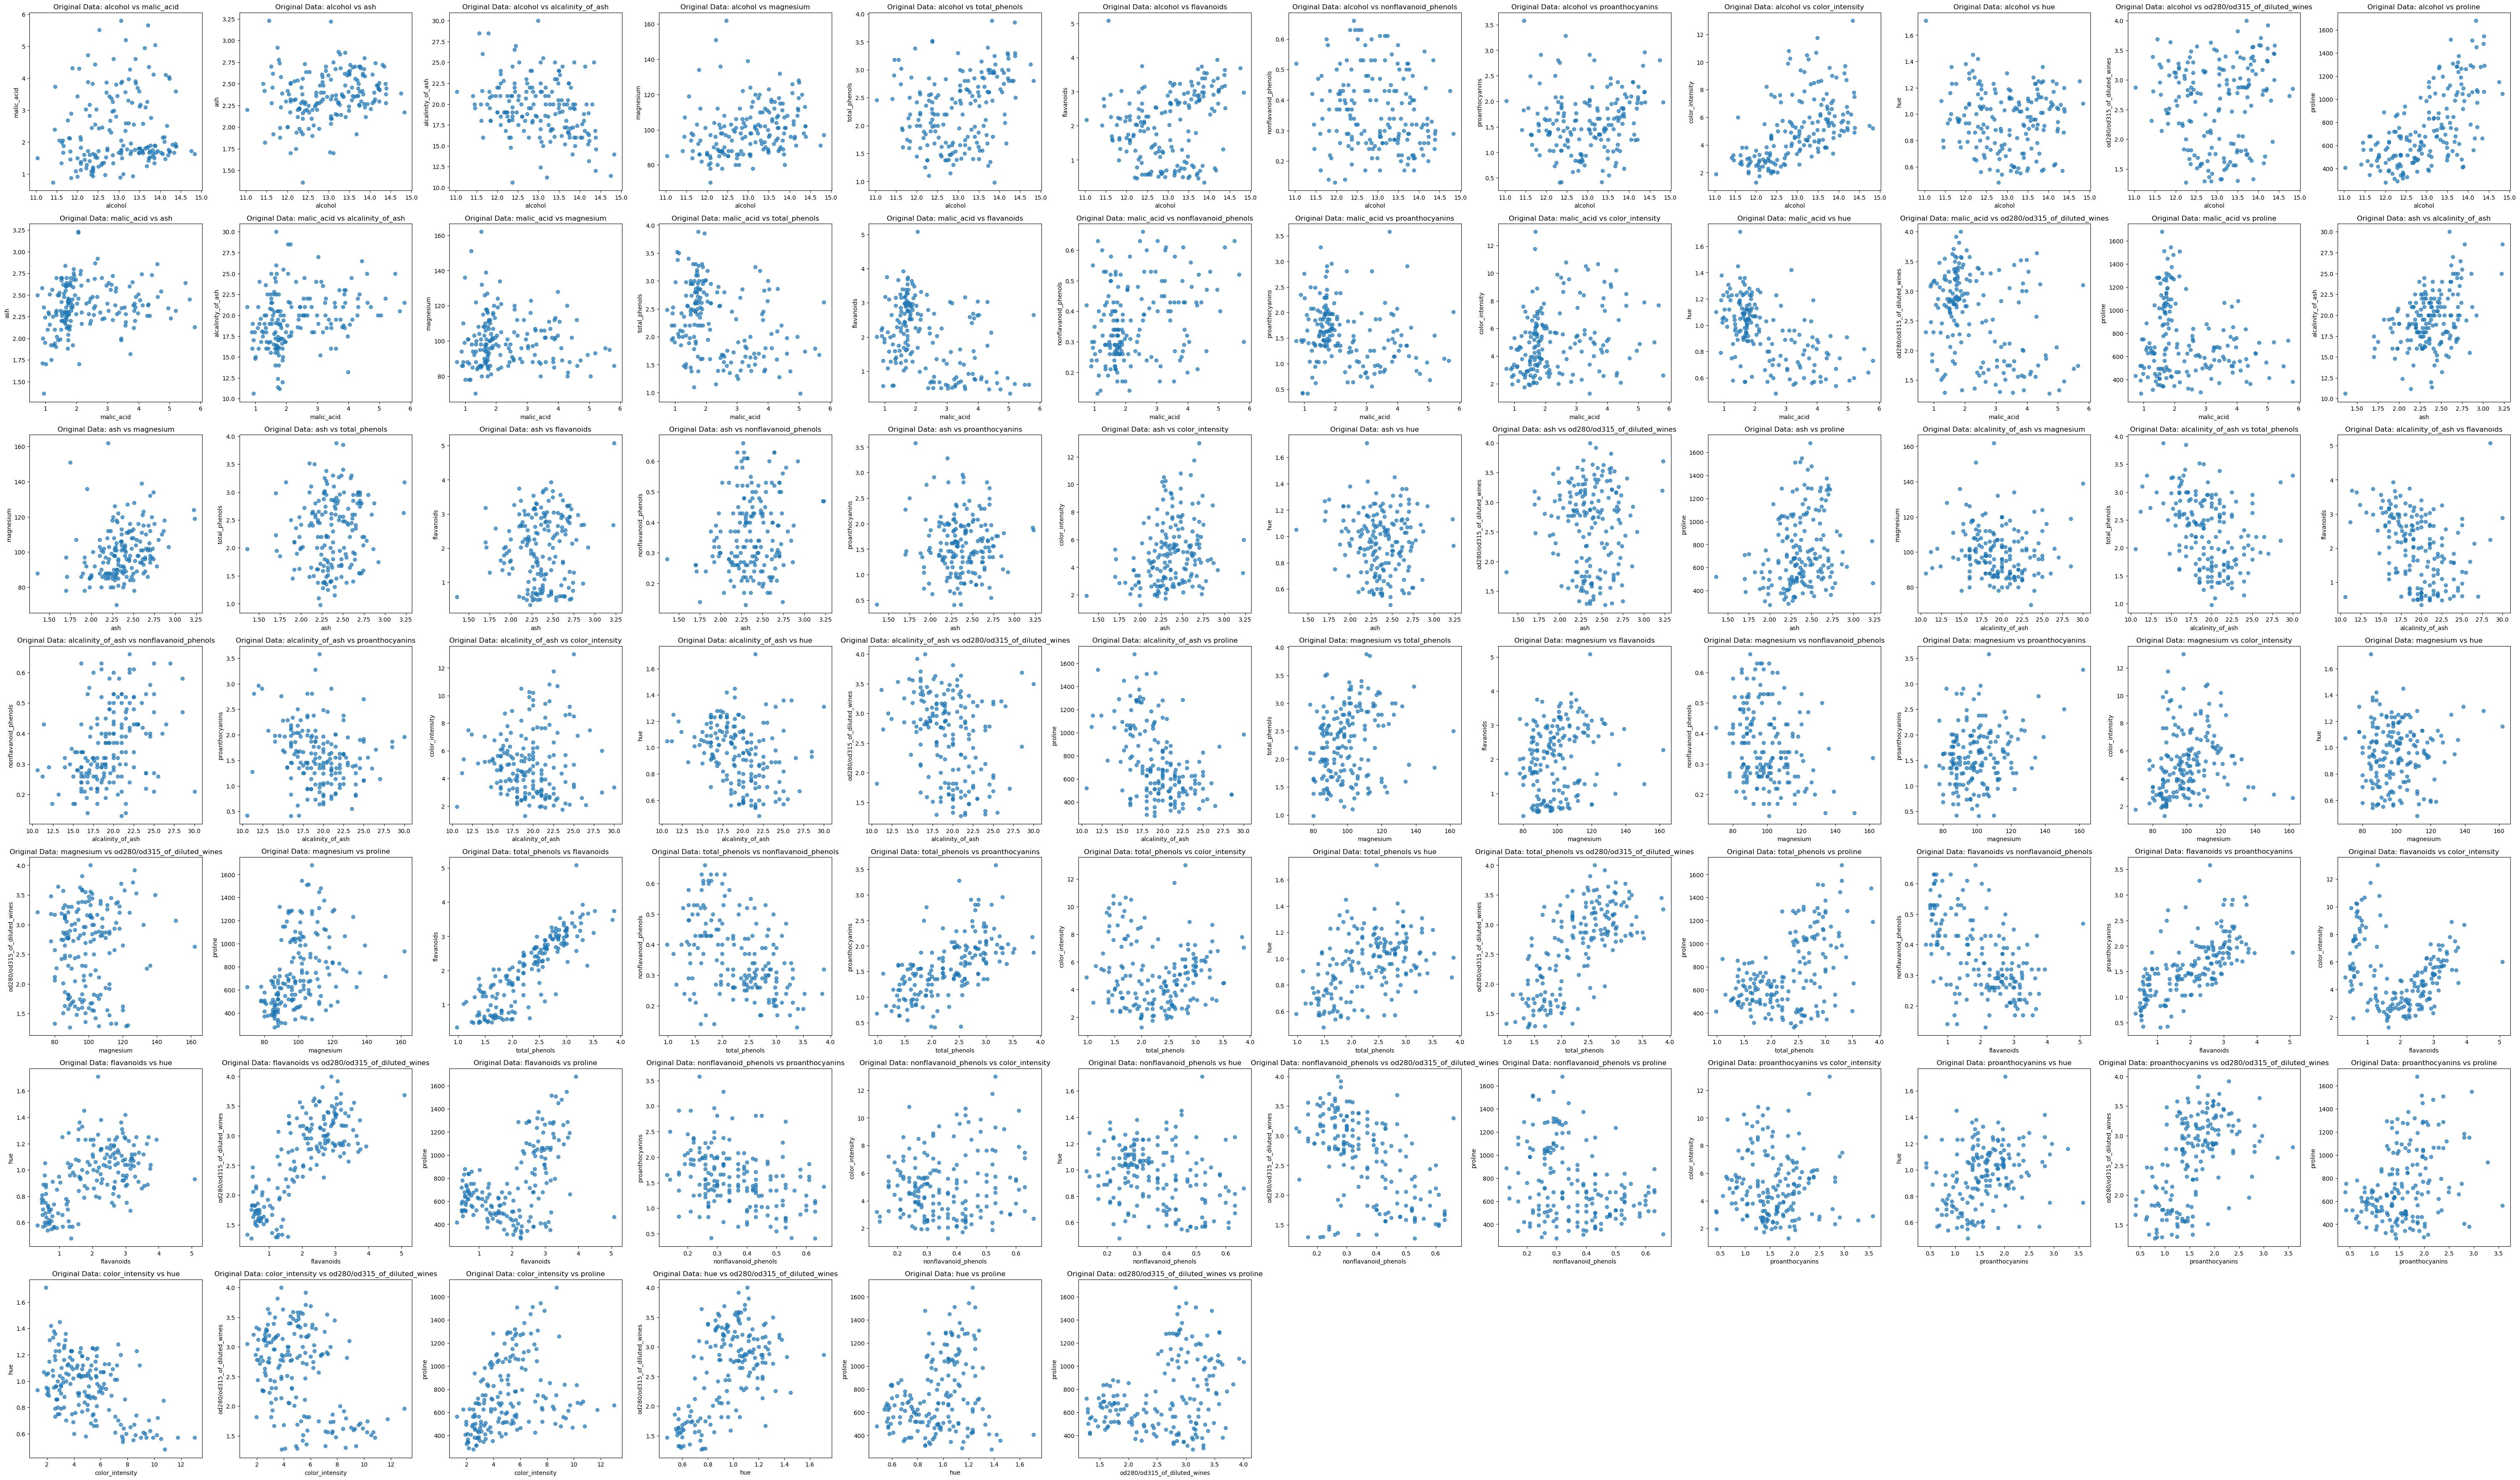

In [3]:
def plot_feature_pairs(data, feature_names, color_labels=None, title_prefix=''):
    """
    Helper function to create scatter plots for all possible pairs of features.
    
    Parameters:
    - data: DataFrame containing the features to be plotted.
    - feature_names: List of feature names to be used in plotting.
    - color_labels: Optional. Cluster or class labels to color the scatter plots.
    - title_prefix: Optional. Prefix for plot titles to distinguish between different sets of plots.
    """
    # Create a figure for the scatter plots
    plt.figure(figsize=(60, 60))
    
    # Counter for subplot index
    plot_number = 1
    
    # Loop through each pair of features
    for i in range(len(feature_names)):
        for j in range(i + 1, len(feature_names)):
            plt.subplot(len(feature_names)-1, len(feature_names)-1, plot_number)
            
            # Scatter plot colored by labels if provided
            if color_labels is not None:
                plt.scatter(data[feature_names[i]], data[feature_names[j]], 
                            c=color_labels, cmap='viridis', alpha=0.7)
            else:
                plt.scatter(data[feature_names[i]], data[feature_names[j]], alpha=0.7)
            
            plt.xlabel(feature_names[i])
            plt.ylabel(feature_names[j])
            plt.title(f'{title_prefix}{feature_names[i]} vs {feature_names[j]}')
            
            # Increment the plot number
            plot_number += 1

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

# Get feature names
feature_names = wine_df.columns

# Use the helper function to plot scatter plots without coloring by cluster labels
plot_feature_pairs(wine_df, feature_names, title_prefix='Original Data: ')

**Question:**
- Do you notice any patterns or relationships between the different features? How might these patterns help in distinguishing between different species?

> Your answer...
> Correlation between flavinoids and pro-anthrocyanins, total_phenols, & od280/od315_of_diluted_wines suggesting these variables may correlate across all "species" of wine (potential for collinearity). it's likely that total_phenols actually represents the sum of flavinoids and nonflavanoid phenols suggesting that these variables may be better represented as compositional data using Aitchinson geometry if included in the same model.
> There does seem to be pockets of clusters with the flavinoids & od280/od315_of_diluted_wines graph indicating two possible "species" (e.g. low in both, high in both)
> Clusters appears around malic acid around 1-2 units, and then another cluster where malic acid varies but total_phenols, flavinoids, proanthrocyanin, and od280/od315_of_diluted_wines remain constant and low.
> clustering also appears like it may occur in plots of flavinoids/total_phenols vs hue/proline/'od280/od315_of_diluted_wines'
> in summation, eye tests suggest several variables may be predictive of clusters.

#### **Question 3:** 
#### Data cleaning

In [4]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Scale all the features in the dataset
scaled_features = scaler.fit_transform(wine_df)

# Create a new DataFrame with scaled features
scaled_wine_df = pd.DataFrame(scaled_features, columns=wine_data.feature_names)

# Display the first few rows of the scaled DataFrame
print(scaled_wine_df.head())

    alcohol  malic_acid       ash  alcalinity_of_ash  magnesium  \
0  1.518613   -0.562250  0.232053          -1.169593   1.913905   
1  0.246290   -0.499413 -0.827996          -2.490847   0.018145   
2  0.196879    0.021231  1.109334          -0.268738   0.088358   
3  1.691550   -0.346811  0.487926          -0.809251   0.930918   
4  0.295700    0.227694  1.840403           0.451946   1.281985   

   total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
0       0.808997    1.034819             -0.659563         1.224884   
1       0.568648    0.733629             -0.820719        -0.544721   
2       0.808997    1.215533             -0.498407         2.135968   
3       2.491446    1.466525             -0.981875         1.032155   
4       0.808997    0.663351              0.226796         0.401404   

   color_intensity       hue  od280/od315_of_diluted_wines   proline  
0         0.251717  0.362177                      1.847920  1.013009  
1        -0.293321  0.406051

Why is it important to standardize the features of a dataset before applying clustering algorithms like K-Means? Discuss the implications of using unstandardized data in your analysis.

> Your answer here ... 
> K-means clustering, like K-Nearest Neighbours creates clusters based on distance between points (e.g. euclidean distance) - thus all measures of distance need to be on the same scale so that 1 unit of variable_a is the same distance as 1 unit of variable_b.

#### **Question 4:** 
#### K-means clustering 

Apply the K-Means clustering algorithm to the Wine dataset. Choose the value 3 for the number of clusters (`k=3`) and fit the model. Assign cluster labels to the original data and add them as a new column in the DataFrame.

    alcohol  malic_acid       ash  alcalinity_of_ash  magnesium  \
0  1.518613   -0.562250  0.232053          -1.169593   1.913905   
1  0.246290   -0.499413 -0.827996          -2.490847   0.018145   
2  0.196879    0.021231  1.109334          -0.268738   0.088358   
3  1.691550   -0.346811  0.487926          -0.809251   0.930918   
4  0.295700    0.227694  1.840403           0.451946   1.281985   

   total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
0       0.808997    1.034819             -0.659563         1.224884   
1       0.568648    0.733629             -0.820719        -0.544721   
2       0.808997    1.215533             -0.498407         2.135968   
3       2.491446    1.466525             -0.981875         1.032155   
4       0.808997    0.663351              0.226796         0.401404   

   color_intensity       hue  od280/od315_of_diluted_wines   proline  Cluster  
0         0.251717  0.362177                      1.847920  1.013009        2  
1        -

c:\Users\markd\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\markd\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


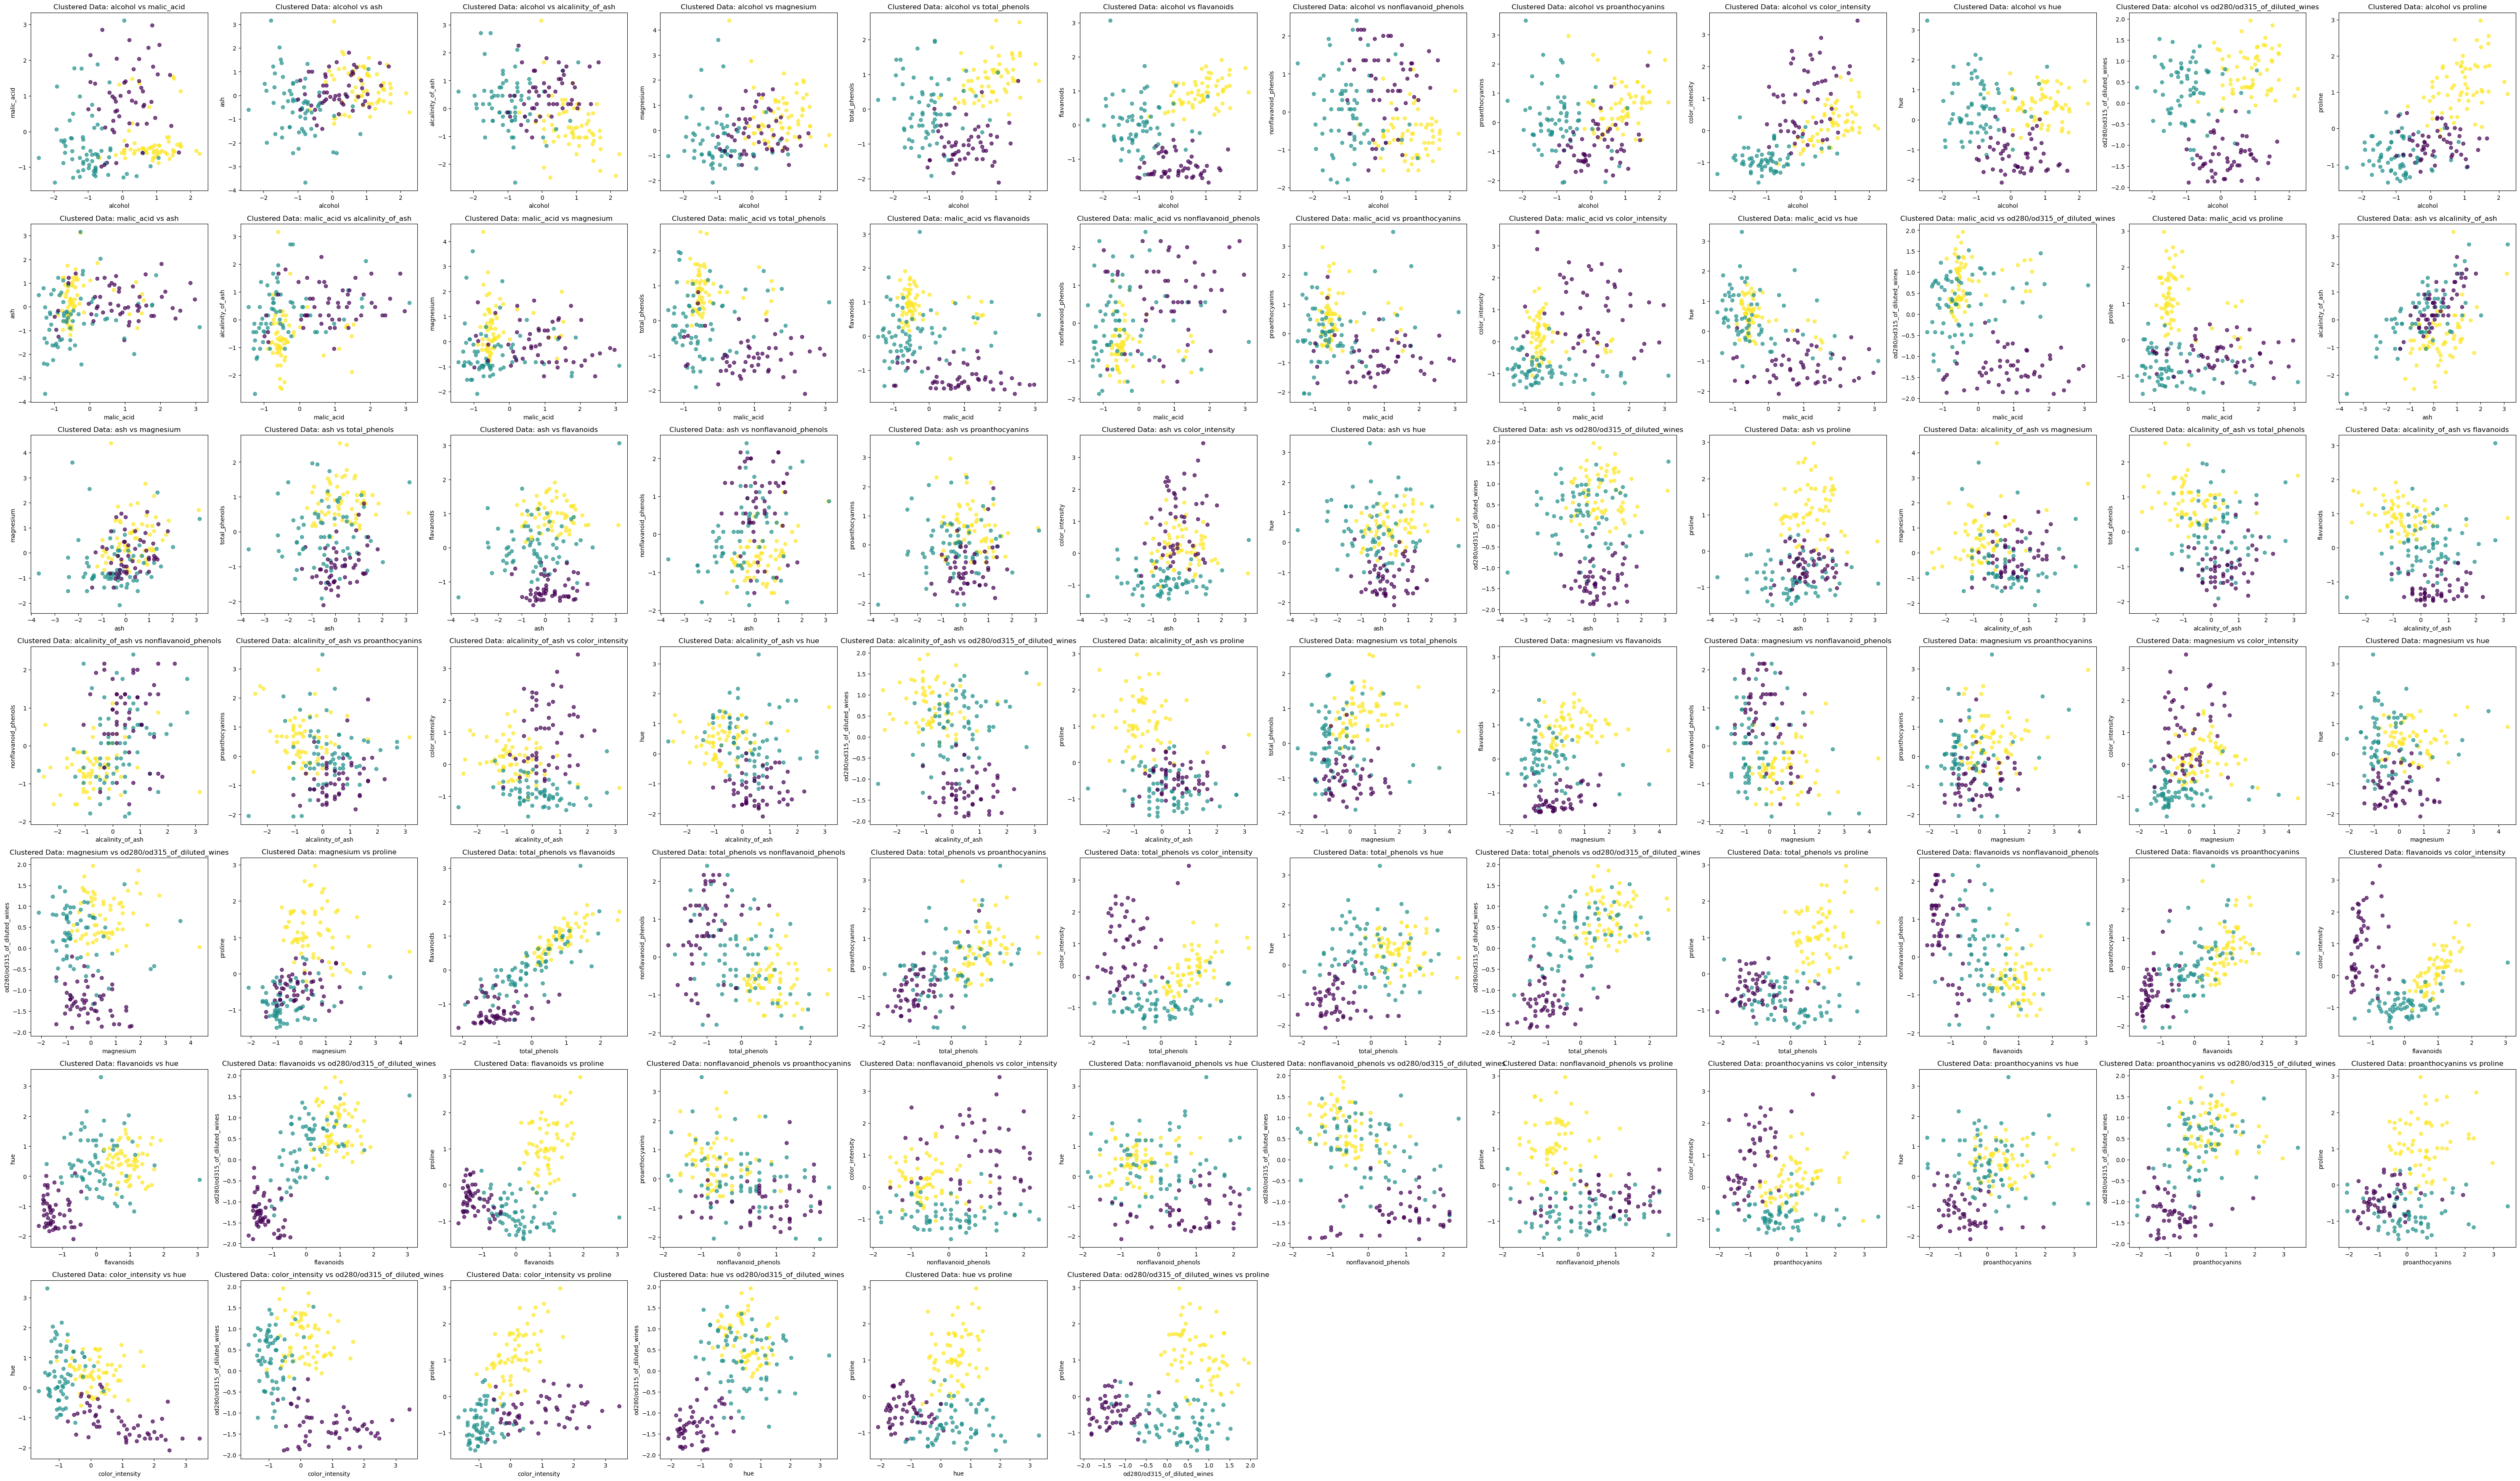

In [5]:
# Your answer...
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit(scaled_wine_df)

clustered_wine_data = scaled_wine_df.copy()
# Assign the cluster labels to the new DataFrame
clustered_wine_data['Cluster'] = clusters.labels_
# Display the first few rows of the clustered DataFrame
print(clustered_wine_data.head())

# Use the helper function to plot scatter plots, colored by cluster labels
plot_feature_pairs(clustered_wine_data, feature_names, color_labels=clustered_wine_data['Cluster'], title_prefix='Clustered Data: ')

We chose `k=3` for the number of clusters arbitrarily. However, in a real-world scenario, it is important to determine the optimal number of clusters using appropriate methods.

**Question**: What is one method commonly used to determine the optimal number of clusters in K-means clustering, and why is this method helpful?

> Your answer here...
> The "elbow method" uses visual inspection a line plot to graph the number of clusters against the within-cluster sum-of-squared-distances (WSSD). The plot will look like an elbow where there's a steep drop in the number of clusters followd by a flatter line after the "elbow", where additional clusters provide significantly less benefit. 
> Determining an optimal K prevents both a merging distinct groups with a small K (results in high total within-cluster WSSD) and b. poor parisomny from excessive subdivision of data with a large K that do not meaningfully improve the WSSD.

#### **Question 5:** 
#### Bootstrapping 

Implement bootstrapping on the mean of `color intensity`. Generate 10000 bootstrap samples, calculate the mean for each sample, and compute a 90% confidence interval.

In [6]:
# Your answer here...
#pretty sure the set seed should be set before the bootstrap sampling rather than after the mean calculation as provided in the original code
np.random.seed(123)

#create list to store bootstrap samples
bootstrap_samples = []

for i in range(10000):
    sample = wine_df.sample(frac=1, replace=True)  # Sample wine_df with replacement
    sample = sample.assign(replicate=i)  # Add replicate number
    bootstrap_samples.append(sample)  # Store the sample

# Combine all bootstrap samples into one DataFrame
boot10000 = pd.concat(bootstrap_samples)

# Calculate the mean color_intensity for each bootstrap sample (replicate)
boot_means = boot10000.groupby('replicate')['color_intensity'].mean().reset_index(name='mean_color_intensity')


mean_color_intensity = boot_means['mean_color_intensity'].mean()

np.random.seed(123)

lower_bound = np.quantile(boot_means['mean_color_intensity'], 0.025)
upper_bound = np.quantile(boot_means['mean_color_intensity'], 0.975)

# Display the result
print(f"Mean of Color Intensity: {mean_color_intensity}")
print(f"90% Confidence Interval of Mean Color Intensity: ({lower_bound}, {upper_bound})")

Mean of Color Intensity: 5.058607567469664
90% Confidence Interval of Mean Color Intensity: (4.724210674157303, 5.4078159999999995)


**Question:**
- Why do we use bootstrapping in this context? What does it help us understand about the mean?

>  Your answer...
> Because this data does not include the full population of wines,  we don't know what the population mean is for color_intensity. using bootstrapping helps estimate the population mean or other potential parameters.

**Question:**
- What is the purpose of calculating the confidence interval from the bootstrap samples? How does it help us interpret the variability of the estimate?

> Your answer...
> Bootstrapping approximates a sampling distribution from the population, as a result we are able to estimate the population mean for color_intensity and a bootstrapped CI where we can be X% confident that the true mean is within the calculated interval.

**Question:**

- Reflect on the variability observed in the bootstrapped means and discuss whether the mean of the color intensity appears to be a stable and reliable estimate based on the confidence interval and the spread of the bootstrapped means.

In [7]:
# Descirbe the color_intensity to find the min and max of color_intensity & other parameters of the sample to help inform this answer.
wine_df['color_intensity'].describe()


count    178.000000
mean       5.058090
std        2.318286
min        1.280000
25%        3.220000
50%        4.690000
75%        6.200000
max       13.000000
Name: color_intensity, dtype: float64

> Your answer here...
> Based on the distribution of color_intensity in the data, it seems like this is a reasonably stable and reliable estimate. The range of the 95%CI is about 0.7 whereas the sample color_intensity ranges from 1.28 to 13, and the standard deviation is 2.3. So 0.7 units seems to be a relatively small range for the 95%CI.
> However, what the "population" of wines means is unclear without context as new wines are being created on a regular basis and even the same style of wine may vary in color intensity.

# Criteria


| **Criteria**                                           | **Complete**                                      | **Incomplete**                                    |
|--------------------------------------------------------|---------------------------------------------------|--------------------------------------------------|
| **Data Inspection**                                    | Data is thoroughly inspected for the number of variables, observations, and data types, and relevant insights are noted. | Data inspection is missing or lacks detail.         |
| **Data Visualization**                                 | Visualizations (e.g., scatter plots) are correctly interpreted to explore relationships between features and species. | Visualizations are not correctly interpreted. |
| **Clustering Implementation**                           | K-Means clustering is correctly implemented, and cluster labels are appropriately assigned to the dataset.            | K-Means clustering is missing or incorrectly implemented. |
| **Bootstrapping Process**                              | Bootstrapping is correctly performed, and results are used to assess variable mean stability. | Bootstrapping is missing or incorrectly performed. |

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Note:

If you like, you may collaborate with others in the cohort. If you choose to do so, please indicate with whom you have worked with in your pull request by tagging their GitHub username. Separate submissions are required.

### Submission Parameters:
* Submission Due Date: `11:59 PM - 06/01/2025`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/LCR/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-6-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.
